In [8]:
import midynet
from midynet.utility import display
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pathlib
import numpy as np
import fractions


display.setup_dir("./")

paths_to_figures = [".", "../../../../papers/p-midynet/paper1-mutual_info/figures"]
paths_to_figures = list(map(pathlib.Path, paths_to_figures))

path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/duality/figure2/")
# path_to_data = pathlib.Path(f"/home/charles_murphy/Documents/ulaval/doctorat/projects/data/midynet-data/duality/figure2/")

path_to_data.exists()

True

## Loading data from experiment

In [9]:


exp = {}
bit_ratio = np.log(2)
hg, hx, mi = {}, {}, {}

all_dynamics = ["glauber", "sis", "cowan"]
for dynamics in all_dynamics:
    name = f"exact-{dynamics}"
    if (path_to_data / name / "config.pickle").exists():
        exp[dynamics] = midynet.Experiment.load_from_file(path_to_data / name / "config.pickle")
        data = exp[dynamics].metrics["recon_information"].data[exp[dynamics].name]
        hg[dynamics] = midynet.Statistics(data, name="prior")
        hx[dynamics] = midynet.Statistics(data, name="evidence")
        mi[dynamics] = midynet.Statistics(data, name="mutualinfo")

xlabel = r"Number of time steps"
titles = {"glauber": r"Glauber", "sis": r"SIS", "cowan": r"Cowan"}
coupling_labels = {"glauber": r"J", "sis": r"\lambda", "cowan": r"\nu"}
coupling_names = {"glauber": "coupling", "sis": r"infection_prob", "cowan": r"nu"}

## Figure 2

[0.25, 0.5, 1]
[2.5, 5.0, 10.0]
[0.5, 1, 2]


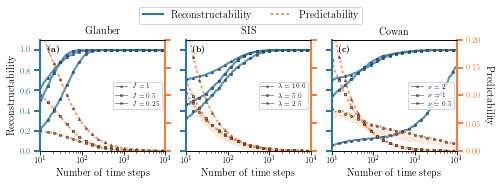

In [29]:
fig, ax = plt.subplots(1, 3, figsize=(7, 7/3), sharex=True, sharey=False)

ax = {dynamics: ax[i] for i, dynamics in enumerate(all_dynamics)}
axx = {dynamics: ax[dynamics].twinx() for i, dynamics in enumerate(all_dynamics)}
# for dynamics in all_dynamics:
#     for i, _ax in enumerate(ax[dynamics]):
#         _ax.get_shared_y_axes().join(_ax, axx[dynamics][i])
    


recon_color = display.med_colors["blue"]
pred_color = display.dark_colors["orange"]


spacing = 7
min_index = 5
recon_yticks = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
pred_yticks = [0, 0.05, 0.1, 0.15, 0.2]

markers = ["o", "s", "^", "*"]
for dynamics_id, dynamics in enumerate(all_dynamics):
    if dynamics not in exp:
        continue
    x = np.array(exp[dynamics].config.data_model.length)
    m_indices = list(range(min_index)) + list(range(min_index, len(x), spacing))
    coupling = exp[dynamics].config.data_model.get_value(coupling_names[dynamics])
    if dynamics == "sis":
        coupling = [c / exp[dynamics].config.data_model.recovery_prob for c in coupling]
    print(coupling)
    alpha = np.linspace(0, 1, len(coupling) + 2)[2:] ** 1.5
    recon = mi[dynamics] / hg[dynamics]
    pred = mi[dynamics] / hx[dynamics]
    for c_index, (c, a) in reversed(list(enumerate(zip(coupling, alpha)))):
#         if c_index != 2:
#             continue
        y = recon if len(coupling) == 1 else recon[:, c_index]
        display.plot_statistics(
            x, y,
            ax=ax[dynamics], 
            color=recon_color,
            alpha=0.75,
            linestyle="-",
            marker=markers[c_index],
            linewidth=2,
            markersize=2,
            markeredgecolor=display.dark_colors["grey"],
            bar=False,
            spacing=5,
        )


        y = pred if len(coupling) == 1 else pred[:, c_index]
        display.plot_statistics(
            x, y,
            ax=axx[dynamics], 
            color=pred_color,
            alpha=0.75,
            linestyle="dotted",
            linewidth=2,
            marker=markers[c_index],
            markeredgecolor=display.dark_colors["grey"],
            markersize=2,
            bar=False,
            spacing=5,
        )
    ax[dynamics].set_xscale("log")
    axx[dynamics].set_xscale("log")

    if dynamics_id == 0:
        ax[dynamics].set_ylabel(r"Reconstructability", fontsize=display.fontsizes["large"])
        ax[dynamics].set_yticks(recon_yticks)
    else:
        ax[dynamics].set_yticklabels([])

    if dynamics_id == len(all_dynamics)-1:
        axx[dynamics].set_ylabel(r"Predictability", fontsize=display.fontsizes["large"], rotation=-90, rotation_mode="anchor", va="bottom")
        axx[dynamics].set_yticks(pred_yticks)
    else:
        axx[dynamics].set_yticklabels([])
    
    ax[dynamics].set_xlabel(xlabel, fontsize=display.fontsizes["large"])
    ax[dynamics].tick_params(axis='both', labelsize=display.fontsizes["medium"])

    ax[dynamics].set_ylim([0, 1.1])
    ax[dynamics].set_xlim([min(x), max(x)])
    axx[dynamics].set_ylim([0, 0.2])


    axx[dynamics].spines['left'].set_color(recon_color)
    axx[dynamics].spines['left'].set_linewidth(2)
    axx[dynamics].spines['right'].set_color(pred_color)
    axx[dynamics].spines['right'].set_linewidth(2)
    axx[dynamics].tick_params(axis='y', colors=pred_color, length=6, width=2)
    handles = []
    for k, c in reversed(list(enumerate(coupling))):
        handles.append(
            Line2D(
                [0], [0], 
                marker=markers[k], 
                linestyle="-", 
                color=display.dark_colors["grey"], 
                label=rf"${coupling_labels[dynamics]} = {c}$", 
                alpha=0.5,
                markersize=2,
                linewidth=1,
            )
        )
    ax[dynamics].legend(handles=handles, loc="center right", fontsize=display.fontsizes["small"], ncol=1, frameon=True)
    ax[dynamics].tick_params(axis='y', colors=recon_color, length=6, width=2)
        
    ax[dynamics].set_title(titles[dynamics], fontsize=display.fontsizes["large"])
            
for dynamics in all_dynamics:
    display.Label.plot(ax[dynamics], loc="top left", fontsize=display.fontsizes["medium"], box=True)
display.Label.clear()

handles = [Line2D([0], [0], marker="None", linestyle="-", color=recon_color, label=r"Reconstructability", alpha=1, lw=2, ms=2)]
handles += [Line2D([0], [0], marker="None", linestyle="dotted", color=pred_color, label=r"Predictability", alpha=1, lw=2, ms=2)]
lg = fig.legend(handles=handles, loc="center", fontsize=display.fontsizes["large"], ncol=2, bbox_to_anchor=(0.5, 1.02))

plt.tight_layout()
# # plt.subplots_adjust(wspace=0.15)

for p in paths_to_figures:
    fig.savefig(p / "svg/p1-figure2.svg", bbox_extra_artists=(lg,), bbox_inches='tight')
    fig.savefig(p / "pdf/p1-figure2.pdf", bbox_extra_artists=(lg,), bbox_inches='tight')
    fig.savefig(p / "png/p1-figure2.png", bbox_extra_artists=(lg,), bbox_inches='tight')